# **[HW1.2] LR vs MLP**
1. Import packages
2. Preprocess Dataset
3. Pytorch Dataset
4. Model
5. Trainer

PyTorch에서 모델을 학습시키는 과정은 크게 3단계로 나누어져 진행됩니다.
1. Initilaize Dataset and DataLoader
2. Initialize Model
3. Train Model

이번 실습에서는 머신러닝 수업때 활용했던 Mnist dataset을 활용하여 logistic regression model과 MLP model을 구현해보고 학습 파이프라인을 익혀보도록 하겠습니다.

# 1. Import packages

> 필요한 package를 설치하고 import합니다

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [1]:
import torch
import torch.nn as nn
print(torch.__version__)
print(torch.cuda.is_available())

1.12.1+cu113
True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# 2. Preprocess Dataset


## Load Dataset

In [3]:
mnist = fetch_openml('mnist_784', cache=False)

In [4]:
mnist.data.shape

(70000, 784)

## Preprocess Dataset

Mnist에 존재하는 각각의 image는 28*28의 픽셀로 구성된 784차원 짜리 벡터로 나타나져 있습니다. 각 픽셀은 0-255사이의 값으로 흰색부터 검은색 사이의 값을 나타냅니다. 

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X = X.values
y = y.values
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


값이 너무 커지는 것을 방지하기 위해 [0,255]사이의 input을 [0,1]의 scale로 조정해줍니다.

In [6]:
X /= 255.0

In [7]:
print(X.min(), X.max())

0.0 1.0


## Split Dataset

학습과 평가를 위한 dataset으로 나눕니다.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
print(X_train.shape) # 80%
print(y_train.shape)
print(X_val.shape) # 10%
print(y_val.shape)
print(X_test.shape) # 10%
print(y_test.shape)

(56000, 784)
(56000,)
(7000, 784)
(7000,)
(7000, 784)
(7000,)


## Visualize Dataset

In [9]:
X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

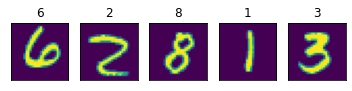

In [11]:
plot_example(X_train, y_train)

# 3. Pytorch Dataset 

PyTorch에서는 Custom Dataset을 사용하기 위해서는 torch.utils.data.Dataset의 형태로 dataset class를 정의해준 이후, torch.utils.data.DataLoader의 형태로 dataloader class를 정의하여 학습시에 model에 forwarding할 data를 sample해줍니다.

(https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

## Dataset

가장 보편적으로 사용되는 map-style의 dataset class는 torch.utils.data.Dataset을 superclass로 받아 __getitem__()과 __len__()함수를 override해줍니다.

```
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data
  
  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)
```

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(np.array(y)).long()
        return x, y

    def __len__(self):
        return len(self.X)

In [13]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

print(len(train_dataset))
print(train_dataset.X.shape)
print(len(val_dataset))
print(val_dataset.X.shape)
print(len(test_dataset))
print(test_dataset.X.shape)

56000
(56000, 784)
7000
(7000, 784)
7000
(7000, 784)


## DataLoader

DataLoader는 train 혹은 validation시 dataset에서 batch를 sampling하기 위한 API입니다 (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

필수적으로 사용하는 option들은 아래와 같습니다.
- dataset: sampling할 dataset
- batch_size: 한번에 sampling할 dataset의 개수
- shuffle: 1 epoch를 기준으로 dataset을 shuffle할지

더 자세한 option이 궁금하시다면 api를 참고해주세요.

In [14]:
batch_size = 64

# shuffle the train data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# do not shuffle the val & test data
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# dataset size // batch_size
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

875
110
110


# 4. Model


Pytorch에서 model을 선언할 때는 torch.nn.Module class를 superclass로 받아 __init__()함수와 forward() 함수를 작성해줍니다.

__init__()함수에는 모델의 파라미터들을 선언하고, forward함수에는 해당 파라미터들을 이용하여 data를 model에 통과시켜줍니다.

https://pytorch.org/docs/stable/generated/torch.nn.Module.html

## Initialize Logistic Regression Model

In [15]:
class LR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LR, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

## Initialize MLP Model

In [16]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 5. Train

이제 선언한 model을 통해 학습을 진행하기 위해서는 model의 파라미터를 최적화할 optimizer가 필요합니다. 이번 실습에서는 가장 보편적으로 사용되는 Adam optimizer를 사용하겠습니다.

### Trainer

In [17]:
class Trainer():
    def __init__(self, trainloader, valloader, testloader, model, optimizer, criterion, device):
        """
        trainloader: train data's loader
        testloader: test data's loader
        model: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.valloader = valloader
        self.testloader = testloader
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        
    def train(self, epoch = 1):
        # 학습을 시작할 때 model을 train-mode로 바꿔주어야함.
        # Question) 왜 model을 train-mode로 바꿔야 할까요?
        # eval() 과 대비된다. eval에서는 평가를 위해서 필요없는 노드를 꺼버린다.
        # 드롭아웃이나 배치놈을 생각해야 한다. 노드를 꺼버리면 안되기 때문이다.
        self.model.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                inputs, labels = data 
                # model에 input으로 tensor를 gpu-device로 보낸다
                inputs = inputs.to(self.device)  
                labels = labels.to(self.device)
                # zero the parameter gradients
                # Question) 왜 optimizer.zero_grad()라는 함수를 사용해야 할까요?
                # 미분값을 계속 남겨두면 나중에 back할때 이것을 같이 더해주게 되서 문제가 된다.
                self.optimizer.zero_grad()    
                # forward + backward + optimize
                # get output after passing through the network
                outputs = self.model(inputs) 
                # compute model's score using the loss function
                loss = self.criterion(outputs, labels)  
                # perform back-propagation from the loss
                loss.backward() 
                # gradient descent를 통해 model의 output을 얻는다.
                self.optimizer.step() 
                running_loss += loss.item()
            
            print('epoch: %d  loss: %.3f' % (e + 1, running_loss / len(self.trainloader)))
            running_loss = 0.0
        val_acc = self.validate()
        return val_acc

    def validate(self):
        # Question) 왜 model을 eval-mode로 바꿔야 할까요?
        # 이제는 평가를 위해서 필요없는 노드를 꺼서 빨리빨리 결과를 낼 수 있도록 한다.
        self.model.eval() 
        correct = 0
        for inputs, labels in self.valloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            output = self.model(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()
        return correct / len(self.valloader.dataset)
        
    def test(self):
        self.model.eval() 
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            output = self.model(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()
        return correct / len(self.testloader.dataset)


## Logistic Regression

In [18]:
input_dim = 784
output_dim = 10
epoch = 4
device = torch.device('cuda')

best_acc = 0.0
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
for lr in lrs:
    model = LR(input_dim=input_dim, output_dim=output_dim).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainer = Trainer(train_dataloader, val_dataloader, test_dataloader, model, optimizer, criterion, device)
    val_acc = trainer.train(epoch = epoch)
    print('val_acc: %.3f' %(val_acc))
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), './best_model')

trainer.model.load_state_dict(torch.load('./best_model'))
test_acc = trainer.test()
print('test_acc: %.3f' %(test_acc))

epoch: 1  loss: 1.182
epoch: 2  loss: 1.273
epoch: 3  loss: 1.298
epoch: 4  loss: 1.272
val_acc: 0.895
epoch: 1  loss: 0.361
epoch: 2  loss: 0.308
epoch: 3  loss: 0.301
epoch: 4  loss: 0.297
val_acc: 0.912
epoch: 1  loss: 0.553
epoch: 2  loss: 0.327
epoch: 3  loss: 0.298
epoch: 4  loss: 0.284
val_acc: 0.919
epoch: 1  loss: 1.380
epoch: 2  loss: 0.734
epoch: 3  loss: 0.557
epoch: 4  loss: 0.475
val_acc: 0.890
test_acc: 0.920


## MLP

In [19]:
input_dim = 784
hidden_dim = 32
output_dim = 10
epoch = 4
device = torch.device('cuda')

best_acc = 0.0
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
for lr in lrs:
    model = MLP(input_dim=input_dim, 
                hidden_dim=hidden_dim,
                output_dim=output_dim).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainer = Trainer(train_dataloader, val_dataloader, test_dataloader, model, optimizer, criterion, device)
    val_acc = trainer.train(epoch = epoch)
    print('val_acc: %.3f' %(val_acc))
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), './best_model')

trainer.model.load_state_dict(torch.load('./best_model'))
test_acc = trainer.test()
print('test_acc: %.3f' %(test_acc))

epoch: 1  loss: 1.140
epoch: 2  loss: 1.059
epoch: 3  loss: 1.106
epoch: 4  loss: 1.206
val_acc: 0.533
epoch: 1  loss: 0.275
epoch: 2  loss: 0.162
epoch: 3  loss: 0.144
epoch: 4  loss: 0.127
val_acc: 0.952
epoch: 1  loss: 0.467
epoch: 2  loss: 0.255
epoch: 3  loss: 0.204
epoch: 4  loss: 0.169
val_acc: 0.952
epoch: 1  loss: 1.293
epoch: 2  loss: 0.550
epoch: 3  loss: 0.410
epoch: 4  loss: 0.354
val_acc: 0.908
test_acc: 0.954
